In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import ml_collections as mlc
import torch
from torch.autograd.functional import jacobian

from Empirical.data import getLogRet
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train, MaskedMSELoss
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC, trainMCMCMasked
from BasicAutoEncoder.Metric import CCACorr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/julianvanmeggelen/Documents/Studie/2022:23/Thesis/Empirical/../Empirical/data.py:16: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,2

/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_51116/3335297575.py:3: RuntimeWarning: invalid value encountered in divide
  y = (y-y.min(axis=0))/(y.max(axis=0)-y.min(axis=0))


(8314, 503)


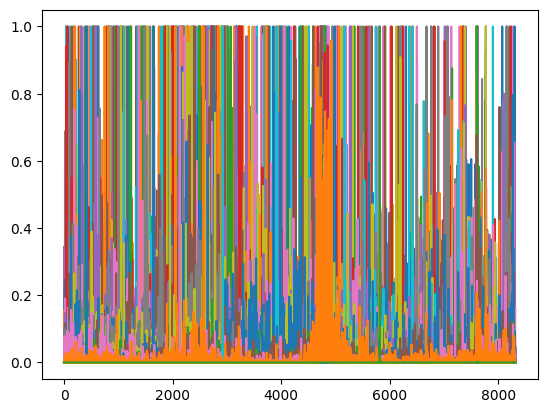

In [18]:

y,mask = getLogRet()
y = y**2
y = (y-y.min(axis=0))/(y.max(axis=0)-y.min(axis=0))
weights = (~mask).astype('float64')
print(y.shape)
plt.plot(y);

In [19]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 10
cfg.obs_dim = y.shape[1]
cfg.p_factor = 2
cfg.p_eps = 0
cfg.T_train = 4096
cfg.T_test = 2048
cfg.T_val = 512
cfg.T = y.shape[0] #8314

#Training config
cfg.batch_size = 512
cfg.lr = 0.0001
cfg.n_epoch = 20

ind_use = np.argwhere(weights[0:cfg.T_train].sum(axis=0)>0)[:,0]

y_use = y[:,ind_use]
weights_use = weights[:,ind_use]
#Create train test val
y_train = y_use[0:cfg.T_train]
weights_train = weights_use[0:cfg.T_train]

y_val = y_use[cfg.T_train:cfg.T_train+cfg.T_val]
weights_val = weights_use[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y_use[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape, weights_train.shape)

(4096, 420) (512, 420) (3706, 420) (4096, 420)


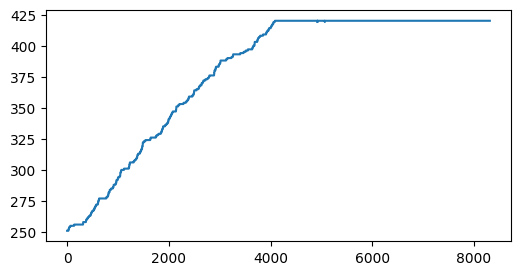

In [20]:
plt.figure(figsize=(6,3))
plt.plot(weights_use.sum(axis=1))

In [21]:

cfg.obs_dim = y_train.shape[1]
dec = Decoder(hidden_dim=[cfg.factor_dim, 100, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False)
enc = Encoder(hidden_dim=[cfg.obs_dim, 100, cfg.factor_dim], activation=nn.Tanh(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
metrics = []
train_hist = trainMCMCMasked(X_train=y_train, X_val = y_val, model=mod, max_iter=20, weights_train=weights_train, weights_val = weights_val, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

/Users/julianvanmeggelen/Documents/Studie/2022:23/Thesis/Empirical/../BasicAutoEncoder/model.py:57: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


Number of trainable paramaters 86630
torch.Size([4096, 420]) torch.Size([512, 420])
1 0.9919490292668343292668343
2 0.0013910219713579863713579863
3 0.0013675770605914295605914295
4 0.0013667244202224538202224538
5 0.0013607958535430953535430953
6 0.0013568650610977784610977784
7 0.0013493856095010415095010415
8 0.0013484357768902555768902555
9 0.0013446513621602207621602207
10 0.001337609865004196850041968
11 0.001337441528448835284488358
12 0.001339775888482108784821087
13 0.001333972206339242063392435
14 0.001325217861449346614493467
15 0.001315921457717195277171952
16 0.001310904961428605614286054
17 0.001301453317864798178647987
18 0.001290348736802116368021162
19 0.001276610215427354154273541
20 0.001259893033420667334206678
21 0.001243146180058829500588295
Training loss: 0.0012431461800588295, Validation Loss: 0.00023588136537000537


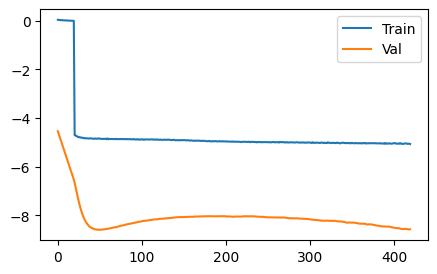

In [12]:
plot_train_hist(train_hist=train_hist)

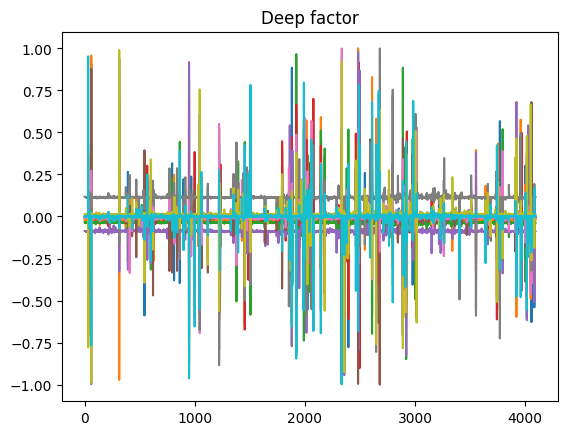

In [13]:
plot_factor_estimates(mod, y_train)

In [14]:
f_test_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_test_hat_centered=  f_test_hat- np.mean(f_test_hat,axis=0)

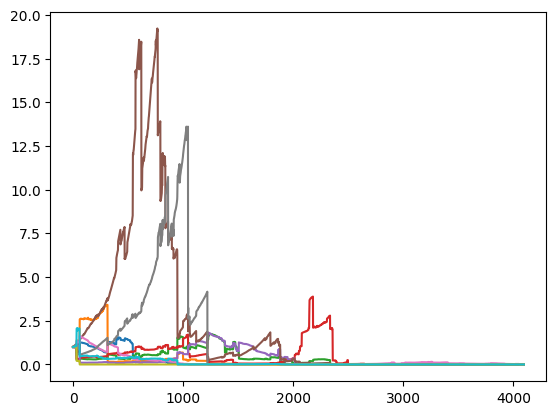

In [15]:
plt.plot(np.cumprod(1+f_test_hat_centered, axis=0));


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 18.15it/s]


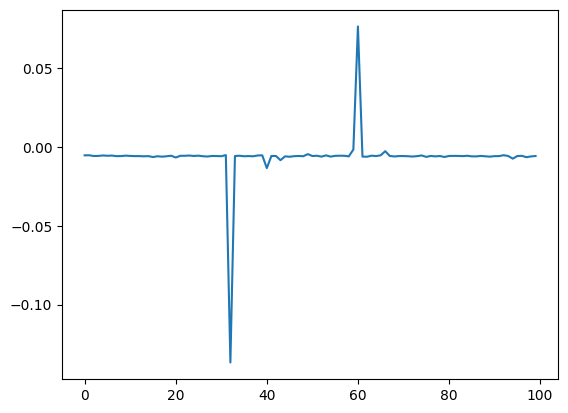

In [17]:
def fobreniusNorm(F):
    return np.sum(F**2)

def computeCI(F, f):
    from tqdm import tqdm
    res = []
    for t in tqdm(range(f.shape[0])):
        
        jac = jacobian(mod.dec, torch.Tensor(f[t]).float()).detach().numpy().T
        sum = 0
        fn = fobreniusNorm(jac)
        for k in range(f.shape[1]):
            for i in range(F.shape[1]):
                sum += f[t,k] * (jac[k,i]**2)/fn
        res.append(sum)
    return res

f_hat = mod.enc(torch.Tensor(y_use).float()).detach().numpy()
F = mod.enc.sequential[0].weight.detach().numpy()
CI = computeCI(F, f_hat[0:100])

plt.plot(CI)

